# Рекомендательная система
### Автор: Лавринов Максим

## Знакомство с данными, предобработка данных

Читаем предоставленные данные. Ниже представлены две ячейки: для чтения в Google Collab и для чтения на компьютере. 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

nomenclature = pd.read_parquet('/content/drive/MyDrive/nomenclature.parquet')
submission_example = pd.read_parquet('/content/drive/MyDrive/submission-example.parquet')
transactions = pd.read_parquet('/content/drive/MyDrive/transactions.parquet')
transactions_for_submission = pd.read_parquet('/content/drive/MyDrive/transactions-for_submission.parquet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

nomenclature = pd.read_parquet('nomenclature.parquet')
submission_example = pd.read_parquet('submission-example.parquet')
transactions = pd.read_parquet('transactions.parquet')
transactions_for_submission = pd.read_parquet('transactions-for_submission.parquet')

#### Рассмотрим файл nomenclature.parquet . 

sku_id – уникальный идентификатор товара
<br>full_name – полное наименование товара
<br>brand – наименование торговой марки
<br>sku_group – группа, к которой принадлежит товар
<br>OTM – признак собственной торговой марки
<br>units – единица измерения для количества 
<br>country – страна производства товара

In [6]:
nomenclature.head()

,sku_id,full_name,brand,sku_group,OTM,units,country
0,0,Масло Lubricrol Magnatec Diesel 10W-40 B4 1л,Lubricrol,Масла моторные (для варповых двигателей),Нет,unknown,ГЕРМАНИЯ
1,723,Трос УранПРОМEthereum буксировочный 4500кг,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ
2,3397,Накидка УранПРОМEthereum на спинку автосиденья...,УранПРОМEthereum,Автотовары,Да,шт,unknown
3,2130,Жилет УранПРОМEthereum световозвращающий,УранПРОМEthereum,Автотовары,Да,шт,unknown
4,3150,Провода УранПРОМEthereum для прикуривания 200А,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ


Получим информацию о файле. Обратим внимание на то, что некоторые поля в файле не заполнены

In [7]:
nomenclature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5103 entries, 0 to 5102
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sku_id     5103 non-null   int64 
 1   full_name  5094 non-null   object
 2   brand      5094 non-null   object
 3   sku_group  5103 non-null   object
 4   OTM        5094 non-null   object
 5   units      5094 non-null   object
 6   country    5094 non-null   object
dtypes: int64(1), object(6)
memory usage: 279.2+ KB


Для начала посмотрим, какие из товаров в файле не имеют названия.

In [9]:
nomenclature[nomenclature['full_name'].isna()]

,sku_id,full_name,brand,sku_group,OTM,units,country
3724,1158,None,None,Ethereum 92,None,None,None
3727,1157,None,None,Ethereum 95 бренд,None,None,None
3728,1163,None,None,Топливо варповое с присадками летнее,None,None,None
3771,1160,None,None,Топливо варповое зимнее,None,None,None
3787,1159,None,None,Ethereum 95,None,None,None
3825,1162,None,None,Топливо варповое с присадками зимнее,None,None,None
3858,2032,None,None,Ethereum 100 бренд,None,None,None
4407,1161,None,None,Топливо варповое летнее,None,None,None
4922,1771,None,None,Топливо варповое с присадками межсезонное,None,None,None


Как видно из предыдущего шага, товары, которые не имеют названия, также не имеют бренда, признака ОТМ, единиц измерения и страны производителя. Судя по группе товара, это различные марки топлива. Только эти девять товаров имеют пропущенные значения.

#### Рассмотрим файл transactions.parquet

sku_id – уникальный идентификатор товара
<br>price – цена, по которой был продан товар
<br>number – количество товаров (если не топливо) 
<br>cheque_id – уникальный идентификатор чека
<br>litrs – количество литров (если товар - топливо)
<br>client_id – уникальный идентификатор клиента (если клиент «представился» при покупке)
<br>shop_id – уникальный идентификатор магазина
<br>date – дата транзакции

In [17]:
transactions.tail()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
7620114,1159,0.002496,0.0,2262516,0.114416,83585.0,96,2171-03-01
7620115,1159,0.002512,0.0,2857410,0.145132,54793.0,84,2171-03-01
7620116,1159,0.002522,0.0,1814506,0.134552,159580.0,36,2171-03-01
7620117,1159,0.002496,0.0,2262671,0.114416,159383.0,96,2171-03-01
7620118,1158,0.002270,0.0,1764664,0.159197,192548.0,77,2171-03-01


Рассмотрим данные о продаже товаров. Для начала визуализируем на графике количество покупок тех или иных товаров. Так как самыми популярными категориями товаров на заправочной станции является топливо, исключим его из визуализации.

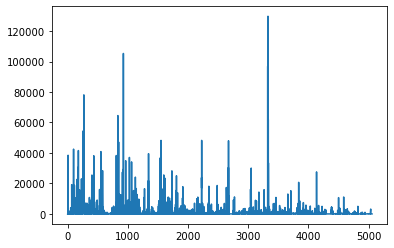

In [5]:
import matplotlib.pyplot as plt

sku_without_fuel = []

for idx in transactions['sku_id'].value_counts().index.sort_values() :
    if idx != 1157 and idx != 1158 and idx != 1159 and idx != 1160 and idx != 1161 and idx != 1162 and idx != 1163 and idx != 1771 and idx != 2032: sku_without_fuel.append(idx)

plt.plot(sku_without_fuel, 
    transactions['sku_id'].value_counts()[sku_without_fuel])

На графике явно видно, что три товара явно выделяются по частоте покупок. Отсортируем товары по количеству продаж.

In [19]:
transactions['sku_id'].value_counts()[sku_without_fuel].sort_values()

2650         1
2832         1
2307         1
4671         1
2839         1
         ...  
834      64544
269      78120
3324     96884
926     105297
3329    129716
Name: sku_id, Length: 4864, dtype: int64

In [7]:
nomenclature[nomenclature['sku_id'] == 3329]

,sku_id,full_name,brand,sku_group,OTM,units,country
3578,3329,Напиток Fly Cafe молокосодержащий кофейный Мок...,Fly Cafe,Кофейные напитки с молоком,Нет,л,РОССИЯ


In [8]:
nomenclature[nomenclature['sku_id'] == 926]

,sku_id,full_name,brand,sku_group,OTM,units,country
2833,926,Напиток Fly Cafe Горячий шоколад кокосовое мол...,Fly Cafe,Прочие напитки кафе,Да,л,unknown


In [9]:
nomenclature[nomenclature['sku_id'] == 3324]

,sku_id,full_name,brand,sku_group,OTM,units,country
2694,3324,Напиток Fly Cafe молокосодержащий кофейный Флэ...,Fly Cafe,Кофейные напитки с молоком,Да,л,unknown


Итак, самые популярные товары (после топлива) - это кофейные напитки с молоком. Можно сделать предположение, что товары этой категории будут часто попадаться в наших будущих рекомендациях.

Проверим данные на корректность

In [10]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620119 entries, 0 to 7620118
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   sku_id     int64         
 1   price      float64       
 2   number     float64       
 3   cheque_id  int64         
 4   litrs      float64       
 5   client_id  float64       
 6   shop_id    int64         
 7   date       datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 465.1 MB


In [11]:
transactions.describe()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id
count,7.620119e+06,7.620119e+06,7.620119e+06,7.620119e+06,7.620119e+06,3.847764e+06,7.620119e+06
mean,1.527023e+03,6.422721e-03,3.887713e-04,1.620232e+06,1.125244e-01,2.015499e+05,4.982808e+01
std,1.150473e+03,7.003628e-03,2.233106e-03,1.014184e+06,1.750252e-02,1.182742e+05,3.188204e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,8.080000e+02,2.770652e-03,4.522493e-04,6.760650e+05,1.041835e-01,1.001890e+05,2.000000e+01
50%,1.159000e+03,6.105695e-03,4.522493e-04,1.605438e+06,1.041835e-01,1.967850e+05,4.400000e+01
75%,2.195000e+03,8.671113e-03,4.522493e-04,2.510364e+06,1.041835e-01,3.075310e+05,7.700000e+01
max,5.058000e+03,1.000000e+00,1.000000e+00,3.407195e+06,1.000000e+00,4.052290e+05,1.100000e+02


Минимальное значение для price равно нулю. Это выглядит подозрительно. Посмотрим, что это за товары и сколько их.

In [21]:
transactions[transactions['price'] == 0]['sku_id'].value_counts()

548     18
11      10
604      5
1962     4
Name: sku_id, dtype: int64

Как видно, таких товаров немного. Так как продажа товара за 0 выглядит некорректной, исключим данные транзакции.

In [22]:
transactions = transactions.loc[transactions['price'] > 0]

transactions[transactions['price'] == 0]['sku_id'].value_counts()

Series([], Name: sku_id, dtype: int64)

Рассмотрим подробнее чеки. Определим, сколько товаров в чеках.

In [23]:
transactions['cheque_id'].value_counts()

2991211    72
2650985    60
2595734    54
2875620    50
3116548    50
           ..
1534340     1
1999853     1
1676504     1
1532916     1
919014      1
Name: cheque_id, Length: 2848238, dtype: int64

Чек на 72 товара выглядит подозрительно, рассмотрим эту закупку подробнее.

In [24]:
transactions[transactions['cheque_id'] == 2991211]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
3999732,847,0.008107,0.000452,2991211,0.104183,NaN,73,2171-05-12
3999733,847,0.008107,0.000452,2991211,0.104183,NaN,73,2171-05-12
3999734,847,0.008107,0.000452,2991211,0.104183,NaN,73,2171-05-12
3999736,847,0.008107,0.000452,2991211,0.104183,NaN,73,2171-05-12
3999737,847,0.008107,0.000452,2991211,0.104183,NaN,73,2171-05-12
...,...,...,...,...,...,...,...,...
4002758,847,0.008107,0.000452,2991211,0.104183,NaN,73,2171-05-12
4002759,847,0.008107,0.000452,2991211,0.104183,NaN,73,2171-05-12
4002760,847,0.008107,0.000452,2991211,0.104183,NaN,73,2171-05-12
4002777,847,0.008107,0.000452,2991211,0.104183,NaN,73,2171-05-12


In [25]:
nomenclature[nomenclature['sku_id'] == 847]

,sku_id,full_name,brand,sku_group,OTM,units,country,cluster
sku_id,,,,,,,,
847,847,Стики Winston fresh,Winston,Табачные изделия,Нет,шт,РОССИЯ,320


Как видно, покупатель купил 72 пачки сигарет. Если учесть, что в сигареты могут продаваться блоками по 20 шт. (на Земле так), то это получается чуть меньше 4 полных блоков. Такая покупка уже выглядит не такой подозрительной.

Рассмотрим период времени, за который были предоставлены данные. Как видно из ячейки ниже, данные предоставлены за пять месяцев: с марта по июль 2171 года включительно.

In [26]:
transactions['date'].describe(datetime_is_numeric=True)

count                          7620082
mean     2171-05-15 05:19:35.533639680
min                2171-03-01 00:00:00
25%                2171-04-06 00:00:00
50%                2171-05-16 00:00:00
75%                2171-06-23 00:00:00
max                2171-07-31 00:00:00
Name: date, dtype: object

В ячейках выше можно заметить, что не все покупатели имеют id. Присвоим таким покупателям id, явно превышающий id остальных покупателей. Это будет id для незнакомцев. Сделаем это для того, чтобы все данные в столбце имели один тип.

In [28]:
transactions['client_id'] = transactions['client_id'].fillna(999999)

In [29]:
transactions[transactions['cheque_id'] == 2991211]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
3999732,847,0.008107,0.000452,2991211,0.104183,999999.0,73,2171-05-12
3999733,847,0.008107,0.000452,2991211,0.104183,999999.0,73,2171-05-12
3999734,847,0.008107,0.000452,2991211,0.104183,999999.0,73,2171-05-12
3999736,847,0.008107,0.000452,2991211,0.104183,999999.0,73,2171-05-12
3999737,847,0.008107,0.000452,2991211,0.104183,999999.0,73,2171-05-12
...,...,...,...,...,...,...,...,...
4002758,847,0.008107,0.000452,2991211,0.104183,999999.0,73,2171-05-12
4002759,847,0.008107,0.000452,2991211,0.104183,999999.0,73,2171-05-12
4002760,847,0.008107,0.000452,2991211,0.104183,999999.0,73,2171-05-12
4002777,847,0.008107,0.000452,2991211,0.104183,999999.0,73,2171-05-12


Рассмотрим данные о количестве проданного топлива.

In [30]:
transactions['litrs'].value_counts()

0.104183    5794666
0.134044      42665
0.124090      27803
0.126151      23767
0.143998      18226
             ...   
0.148111          1
0.106404          1
0.235580          1
0.104188          1
0.000000          1
Name: litrs, Length: 19851, dtype: int64

Очень подозрительно выглядит то, что транзакция без топлива только одна. Исходя из того, что топливо и товар проходят разными транзакциями, значений с 0 должно быть намного больше. Также подозрительным выглядит количество 5794666 у значения 0.104183 - оно превышает следующее по количеству значение более, чем в сотню раз. Видимо, это ошибка в записях транзакций, сделаем корректировку на это значение.

In [31]:
def get_correct_litrs (litrs, value_of_error):
    correct_value = litrs - value_of_error
    if correct_value < 0 : return 0
    else : return correct_value
    
litrs_mode = transactions['litrs'].mode()[0]

transactions['litrs'] = transactions.apply(
    lambda x: get_correct_litrs(x['litrs'], litrs_mode)
    , axis = 1)

In [32]:
transactions['litrs'].value_counts()

0.000000    5795239
0.029861      42665
0.019907      27803
0.021967      23767
0.039814      18226
             ...   
0.029980          1
0.295241          1
0.000004          1
0.123434          1
0.024757          1
Name: litrs, Length: 19295, dtype: int64

Сохраним обработанный файл. Если придется перезапускать программу, не будет необходимости снова обрабатывать данные.

In [33]:
transactions.to_parquet('transactions_modified.parquet')

In [34]:
import pandas as pd
transactions = pd.read_parquet('transactions_modified.parquet')

## Разработка рекомендательной системы

Перейдем к разработке самой рекомендательной системы.

В данной системе используется кластеризация товаров по группам и выдача рекомендаций на основе частоты покупок товаров разных групп вместе.

### Кластеризация товаров

Для начала кластеризуем товары на основе названия. Предполагается, что товары со схожим названием, скорее всего, принадлежат группе взаимозаменяемх товаров.

В предыдущем блоке мы заметили, что топливо не имеет названия. Продублируем в название топлива его группу.

In [10]:
nomenclature['full_name'] = nomenclature['full_name'].fillna(nomenclature['sku_group'])

In [11]:
nomenclature[nomenclature['sku_id'] == 1158]

,sku_id,full_name,brand,sku_group,OTM,units,country
3724,1158,Ethereum 92,None,Ethereum 92,None,None,None


Отсортируем товары по SKU. Это поможет более быстрым способом проставить номера полученных категорий товарам.

In [12]:
nomenclature = nomenclature.sort_values(by='sku_id')
nomenclature.index = nomenclature['sku_id']

Количество кластеров определено эмпирически с рассчетом на то, что в каждом кластере будет около пяти товаров. Так в дальнейшем для рекомендации 20 товаров, нам понадобится около 4 кластеров. Это должно обеспечить небольшое разнообразие в рекомендациях. Так, рекомендованные товары будут схожи между собой, но не будут состоять полностью из взаимозаменяемых позиций.

In [13]:
n_clusters = round(len(nomenclature['sku_id'])/5)

Кластеризуем товары. В качестве векторайзера для текста возьмем TfidfVectorizer из библиотеки sklearn с двумя n-граммами. Так названия будут векторизвоваться как словосочетания, что должно дать хороший результат. Так как названия товаров не длинные, использовать длинные n-граммы нет смысла.

В качестве модели для кластеризации используем алгоритм K ближайших соседей с ограничением по количеству выходных кластеров.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
X = vectorizer.fit_transform(nomenclature['full_name'])

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
result = pd.concat([nomenclature['full_name'],pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())],axis=1)
result['cluster'] = kmeans.predict(X)

In [15]:
nomenclature['cluster'] = result['cluster']

In [16]:
nomenclature.head()

,sku_id,full_name,brand,sku_group,OTM,units,country,cluster
sku_id,,,,,,,,
0,0,Масло Lubricrol Magnatec Diesel 10W-40 B4 1л,Lubricrol,Масла моторные (для варповых двигателей),Нет,unknown,ГЕРМАНИЯ,69
1,1,Хомуты FORTISFLEX пластиковые 15-30см 50шт,FORTISFLEX,Автотовары,Нет,шт,unknown,336
2,2,Держатель G-Fly (СТМ) для смартфонов на дефлек...,G-Fly (СТМ),Автотовары,Да,шт,КИТАЙ,654
3,3,Держатель SAPFIRE Mobile SM-0944 для телефона ...,SAPFIRE,Автотовары,Нет,шт,КИТАЙ,480
4,4,Устройство зарядное G-Fly (СТМ) SGD-0913 USB порт,G-Fly (СТМ),Автотовары,Да,шт,КИТАЙ,77


###  Получение рекомендаций

Для получения рекомендаций нам потребуется матрица, в которой будут записаны количесво совместых покупок товаров из разных кластеров. 

In [35]:
import numpy as np

correlation_matrix = np.zeros((n_clusters, n_clusters))

Чтобы заполнить матрицу, для начала сгруппируем покупки по чекам и посмотрим, какие товары были куплены вместе.

In [37]:
cheques_with_sku = transactions[['cheque_id', 'sku_id']].groupby('cheque_id').agg(lambda x: list(x.unique()))

In [38]:
cheques_with_sku['sku_id']

cheque_id
0               [967, 1159]
1          [2757, 270, 569]
2                [98, 2226]
3               [782, 2242]
4               [554, 1158]
                 ...       
3407191         [151, 1158]
3407192         [151, 1158]
3407193              [1159]
3407194              [1158]
3407195         [1158, 151]
Name: sku_id, Length: 2848238, dtype: object

Заполним матрицу количеством покупок товаров вместе. Обратим внимание, что покупка товара X с товаром Y для покупателя равнозначна покупке товара Y с товаром X. Поэтому матрица должна получиться симметричной.

In [39]:
for line in cheques_with_sku['sku_id']:
  if len(line) >= 2 :
    for i in range(len(line)):
      for j in range(len(line)):
        if i != j :
          ii = nomenclature.loc[line[i]]['cluster']
          jj = nomenclature.loc[line[j]]['cluster']
          correlation_matrix[ii][jj] = correlation_matrix[ii][jj] + 1

In [41]:
correlation_matrix

array([[4.00000e+00, 2.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [2.00000e+00, 2.23656e+05, 3.10000e+01, ..., 0.00000e+00,
        0.00000e+00, 2.37000e+02],
       [0.00000e+00, 3.10000e+01, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 2.37000e+02, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

Теперь выведем SKU, которые нам имеет смысл рекомендовать, в отдельный список.

In [187]:
sku_for_rec = list(nomenclature[(nomenclature['sku_group'] == 'Вода') | 
                                    (nomenclature['sku_group'] == 'Сладкие Уранированные напитки, холодный чай') | 
                                    (nomenclature['sku_group'] == 'Кофейные напитки с молоком') | 
                                    (nomenclature['sku_group'] == 'Энергетические напитки') | 
                                    (nomenclature['sku_group'] == 'Снеки') | 
                                    (nomenclature['sku_group'] == 'Соки и сокосодержащие напитки')]['sku_id'])

Далее идут две функции, которые отвечают за выдачу рекомендаций: get_recomendate_cluster и get_recomendate_sku

get_recomendate_cluster принимает на вход список кластеров, для которых нужно дать рекомендации, матрицу корреляций между кластерами, список ранее рекомендованных кластеров и количесво кластеров в рекомендации. Количество кластеров в рекомендации помогает получить за один проход функции столько кластеров, сколько нужно для получения необходимого количества товаров.

get_recomendate_sku принимает на вход список рекомендованных кластеров, и список товаров, которые мы хотим рекомендовать.

In [12]:
def get_recomendate_cluster (cluster_list, matrix, list_of_used_clusters, count_of_recs):

  corr_matr = matrix.copy()
  best_pair = []

  for count in range(count_of_recs):

    cluster = list(corr_matr[cluster_list[0]]).index(corr_matr[cluster_list[0]].max())
    while cluster in list_of_used_clusters:

      max_correlation = -1
      for i in cluster_list:

        if corr_matr[i].max() > max_correlation:
          cluster = list(corr_matr[i]).index(corr_matr[i].max())
          corr_matr[i][cluster] = -1

    best_pair.append(cluster)
    list_of_used_clusters.append(cluster)

  return best_pair

In [235]:
def get_recomendate_sku (clusters, list_of_recomendated_sku):
  recomendations = []
  for i in clusters:
    sku = nomenclature[nomenclature['cluster'] == i]['sku_id']
    for j in sku:
      if j in list_of_recomendated_sku:
        recomendations.append(j)

  return recomendations

Итак, приступим к рекомендациям. Для начала сгруппируем чеки, для которых мы хотим получить рекомендации, и посмотрим указанные в них товары.

In [311]:
cheques_with_sku_for_submission = transactions_for_submission[['cheque_id', 'sku_id']].groupby('cheque_id').agg(lambda x: list(x.unique()))

Посмотрим количесво чеков

In [312]:
len(list(cheques_with_sku_for_submission['sku_id'].index))

315228

Создадим новый датафрейм для записи рекомендаций. После этого пройдемся циклом по чекам и запишем рекомендации для каждого из них.

In [313]:
submission_Lavrinov = pd.DataFrame(columns=['cheque_id', 'sku_id', 'position'])

In [ ]:
for i in list(cheques_with_sku_for_submission['sku_id'].index) :
  clusters = [nomenclature.loc[j]['cluster'] for j in cheques_with_sku_for_submission['sku_id'][i]]
  list_of_used_clusters = []
  submission = []
  while len(submission) < 20:
    submission = submission + get_recomendate_sku(get_recomendate_cluster(clusters, correlation_matrix, list_of_used_clusters, 4), sku_for_rec)
  rec_list = submission[:20]
  for j in range(len(rec_list)):
    submission_Lavrinov = submission_Lavrinov.append({'cheque_id' : i, 'sku_id': rec_list[j], 'position' : j + 1}, ignore_index=True)

Сохраним полученный файл.

In [ ]:
submission_Lavrinov.to_parquet('submission_Lavrinov.parquet')

Убедимся, что вид полученного файла совпадает с видом предоставленного примера.

In [309]:
submission_Lavrinov

,cheque_id,sku_id,position
0,734259,18,1
1,734259,22,2
2,734259,88,3
3,734259,97,4
4,734259,160,5
...,...,...,...
12275,735581,405,16
12276,735581,411,17
12277,735581,571,18
12278,735581,574,19


In [14]:
submission_example

,cheque_id,sku_id,position
0,734259,1499,1
1,734259,1053,2
2,734259,1278,3
3,734259,3719,4
4,734259,3292,5
5,734259,1951,6
6,734259,3186,7
7,734259,3333,8
8,734259,2921,9
9,734259,2194,10
